# Morgage data analsysis and model

This project was a capstone project of the Microsoft professional certifical in Datascience in 2019, before the whole program was stopped. I am including it here for my own reference and as a source of information. The notebook will be cleaned up a bit as this was used for generating the charts and data insignts used in the final report.

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

In [8]:
def CategoricalPlots(data, cols, ref='accepted'):
    '''
    Plot categorical data from the DataFrame 'data' using the columns in cols.
    Split the categorical data in line with a label reference
    '''
    if not('dummy' in data.columns):
        data['dummy'] = np.ones(shape = data.shape[0])
    for col in cols:
        print(col)
        counts = data[['dummy', ref, col]].groupby([ref, col], as_index = False).count()
        _ = plt.figure(figsize = (14,4))
        plt.subplot(1, 2, 1)
        temp = counts[counts[ref] == 0][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n not accepted')
        plt.ylabel('count')
        plt.subplot(1, 2, 2)
        temp = counts[counts[ref] == 1][[col, 'dummy']]
        plt.bar(temp[col], temp.dummy)
        plt.xticks(rotation=90)
        plt.title('Counts for ' + col + '\n accepted')
        plt.ylabel('count')
        plt.show()


def DistPlots(data, columns):
    for column in columns:
        fig, ax = plt.subplots(figsize=(11.7,8.27))
        ax = sns.distplot(data[column], ax=ax)
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
        
def DistPlotsSplit(data, columns, ref=''):
    '''
    Plot several distributions with a reference column
    '''
    if ref != '':
        unique = data[ref].unique()
    for column in columns:
        if ref != '':
            ax = sns.distplot(data.loc[data[ref]==unique[0], column])
            ax = sns.distplot(data.loc[data[ref]==unique[1], column], ax=ax)
        else:
            ax = sns.distplot(data[column])
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()
        
def ReplaceWithMedian(data, ref = 'property_type', col='applicant_income'):
    '''
    Replacing a missing value in the "col" based on the median calculation from the reference column
    '''
    for value in data[ref].unique():
        replace_median = data[data[ref]==value][col].median()
        data.loc[(data[ref]==value) & (data[col].isnull()), col] = replace_median

## Training data preparation analysis

Intially, let's look at the training data

In [9]:
train_data = pd.read_csv('datasets/train_values.csv', index_col=0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_type                       500000 non-null  int64  
 1   property_type                   500000 non-null  int64  
 2   loan_purpose                    500000 non-null  int64  
 3   occupancy                       500000 non-null  int64  
 4   loan_amount                     500000 non-null  float64
 5   preapproval                     500000 non-null  int64  
 6   msa_md                          500000 non-null  int64  
 7   state_code                      500000 non-null  int64  
 8   county_code                     500000 non-null  int64  
 9   applicant_ethnicity             500000 non-null  int64  
 10  applicant_race                  500000 non-null  int64  
 11  applicant_sex                   500000 non-null  int64  
 12  applicant_income

There is a lot of numerical columns, but we have to consider that in many cases, those are in fact representing categories. These categories are known:
- loan_type: 1 Conventional, 2 FHA-insured, 3 VA-guaranteed, 4 FSA/RHS
- property_type: 1 One to four-family, 2 Manufactured housing, 3 Multifamily
- loan_purpose: 1 Home purchase, 2 Home improvement, 3 Refinancing
- occupancy: 1 Owner-occupied', 2 Not owner-occupied, 3 Not applicable
- preapproval: 1 Preapproval was requested, 2 Preapproval was not requested, 3 Not applicable
- applicant_ethnicity: 1 Hispanic or Latino, 2 Not Hispanic or Latino, 3 Information not provided, 4 Not applicable,5 No co-applicant
- applicant_race: 1 American Indian or Alaska Native', 2 Asian', 3 Black or African American', 4 Native Hawaiian or Other Pacific Islander', 5 White', 6 Information not provided, 7 Not applicable,8 No co-applicant
- applicant_sex: 1 Male, 2 Female, 3 Information not provided, 4 Not applicable, 5 Not applicable

Some of the collumns seem to have missing data, mostly it seems to be concentrated in the numerical columns. We'll see later whether this will have an impact on the overal data quality.

Load the training values and the training labels and merge them together. This way we will be able to look at the acceptance and rejection of the mortgate application based on the available data. After mergning we should have 22 columns - 21 features and 1 label.

In [11]:
train_labels = pd.read_csv('datasets/train_labels.csv', index_col=0)
data = train_data.merge(train_labels, on='row_id')
print(data.shape)

(500000, 22)


### Data types and conversion

As a next step, let's define different groups of columns indicating the various parts of the dataset. Let's split the columns based on what is the type of the information they contain:
-  Property location
-  Lender as as a separate value
-  Numerical columns (other than the onces in the categories above)
-  Categorical columns (other that the ones in the categories above)

And set their correct datatype for subsequent operations.

In [12]:
cols_numerical = ['loan_amount', 'applicant_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                  'ffiecmedian_family_income', 'minority_population_pct', 'tract_to_msa_md_income_pct','population']
cols_categorical = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 
                    'applicant_ethnicity', 'applicant_race', 'applicant_sex','co_applicant', 'msa_md', 'state_code', 'county_code']

cols_property_location = ['msa_md', 'state_code', 'county_code']

cols_lender = ['lender']

In [13]:
data[cols_categorical] = data[cols_categorical].astype('category')
data[cols_property_location] = data[cols_property_location].astype('category')
data['lender'] = data['lender'].astype('category')
data[['co_applicant', 'accepted']] = data[['co_applicant', 'accepted']].astype(bool)

Is the dataset label biased? Let's check the amount of labels for both categories of mortgage approval or non-approval, so see whether there is any bias in the dataset.

In [14]:
print(data['accepted'].value_counts())

True     250114
False    249886
Name: accepted, dtype: int64


The result of the data show that the labels are almost evenly matched between approved and not-approved mortgages. This should hopefully not influence the training algorithm.

### Missing values

Let's check the information provided in the complete dataset, and whether there are any missing values. We also know that we have missing values in the property location indicated as -1 so let's check how many values are missing there as well.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   loan_type                       500000 non-null  category
 1   property_type                   500000 non-null  category
 2   loan_purpose                    500000 non-null  category
 3   occupancy                       500000 non-null  category
 4   loan_amount                     500000 non-null  float64 
 5   preapproval                     500000 non-null  category
 6   msa_md                          500000 non-null  category
 7   state_code                      500000 non-null  category
 8   county_code                     500000 non-null  category
 9   applicant_ethnicity             500000 non-null  category
 10  applicant_race                  500000 non-null  category
 11  applicant_sex                   500000 non-null  category
 12  ap

From the data above we can see that there are several numerical values with missing values, as well as quite a significant number of rows with msa_md information missing.

For better readability, let's replace the categorical numbers with the actual cagetory name. This will help with the additional data visualization later.

In [16]:
codes = [['loan_type', {1: 'Conventional',
                        2: 'FHA-insured',
                        3: 'VA-guaranteed',
                        4: 'FSA/RHS'}],
         ['property_type', {1: 'One to four-family',
                            2: 'Manufactured housing',
                            3: 'Multifamily'}],
         ['loan_purpose', {1: 'Home purchase',
                           2: 'Home improvement',
                           3: 'Refinancing'}],
         ['occupancy', {1: 'Owner-occupied',
                        2: 'Not owner-occupied',
                        3: 'Not applicable'}],
         ['preapproval',{1: 'Preapproval was requested',
                         2: 'Preapproval was not requested',
                         3: 'Not applicable'}],
         ['applicant_ethnicity',{1: 'Hispanic or Latino',
                                   2: 'Not Hispanic or Latino',
                                   3: 'Information not provided',
                                   4: 'Not applicable',
                                   5: 'No co-applicant'}],
         ['applicant_race', {1: 'American Indian or Alaska Native',
                             2: 'Asian',
                             3: 'Black or African American',
                             4: 'Native Hawaiian or Other Pacific Islander',
                             5: 'White',
                             6: 'Information not provided',
                             7: 'Not applicable',
                             8: 'No co-applicant'}],
         ['applicant_sex', {1: 'Male',
                            2: 'Female',
                            3: 'Information not provided',
                            4: 'Not applicable',
                            5: 'Not applicable'}]
]
for code in codes:
    col = code[0]
    dic = code[1]
    data[col] = [dic[x] for x in data[col]]

In [18]:
for col in cols_property_location:
    if data[col].dtype != object:
        count = 0
        count = [count + 1 for x in data[col] if x == -1]
        print (col + ' ' + str(sum(count)))

msa_md 76982
state_code 19132
county_code 20466


# Data exploration

Let's first explore whether there are any relationships in the data.

In [19]:
desc = data[cols_numerical].describe()
desc
#desc.to_csv('train_values_description.csv')

,loan_amount,applicant_income,number_of_owner-occupied_units,number_of_1_to_4_family_units,ffiecmedian_family_income,minority_population_pct,tract_to_msa_md_income_pct,population
count,500000.000000,460052.000000,477435.000000,477470.000000,477560.000000,477534.000000,477486.000000,477535.000000
mean,221.753158,102.389521,1427.718282,1886.147065,69235.603298,31.617310,91.832624,5416.833956
std,590.641648,153.534496,737.559511,914.123744,14810.058791,26.333938,14.210924,2728.144999
min,1.000000,1.000000,4.000000,1.000000,17858.000000,0.534000,3.981000,14.000000
25%,93.000000,47.000000,944.000000,1301.000000,59731.000000,10.700000,88.067250,3744.000000
50%,162.000000,74.000000,1327.000000,1753.000000,67526.000000,22.901000,100.000000,4975.000000
75%,266.000000,117.000000,1780.000000,2309.000000,75351.000000,46.020000,100.000000,6467.000000
max,100878.000000,10139.000000,8771.000000,13623.000000,125248.000000,100.000000,100.000000,37097.000000


We can see that there are extreme maximum values present in the data. For example, the loan_amount the mean value is 221, but the maximum is more than 100000.

Is there any obvious relationship amonsts the numerical features?

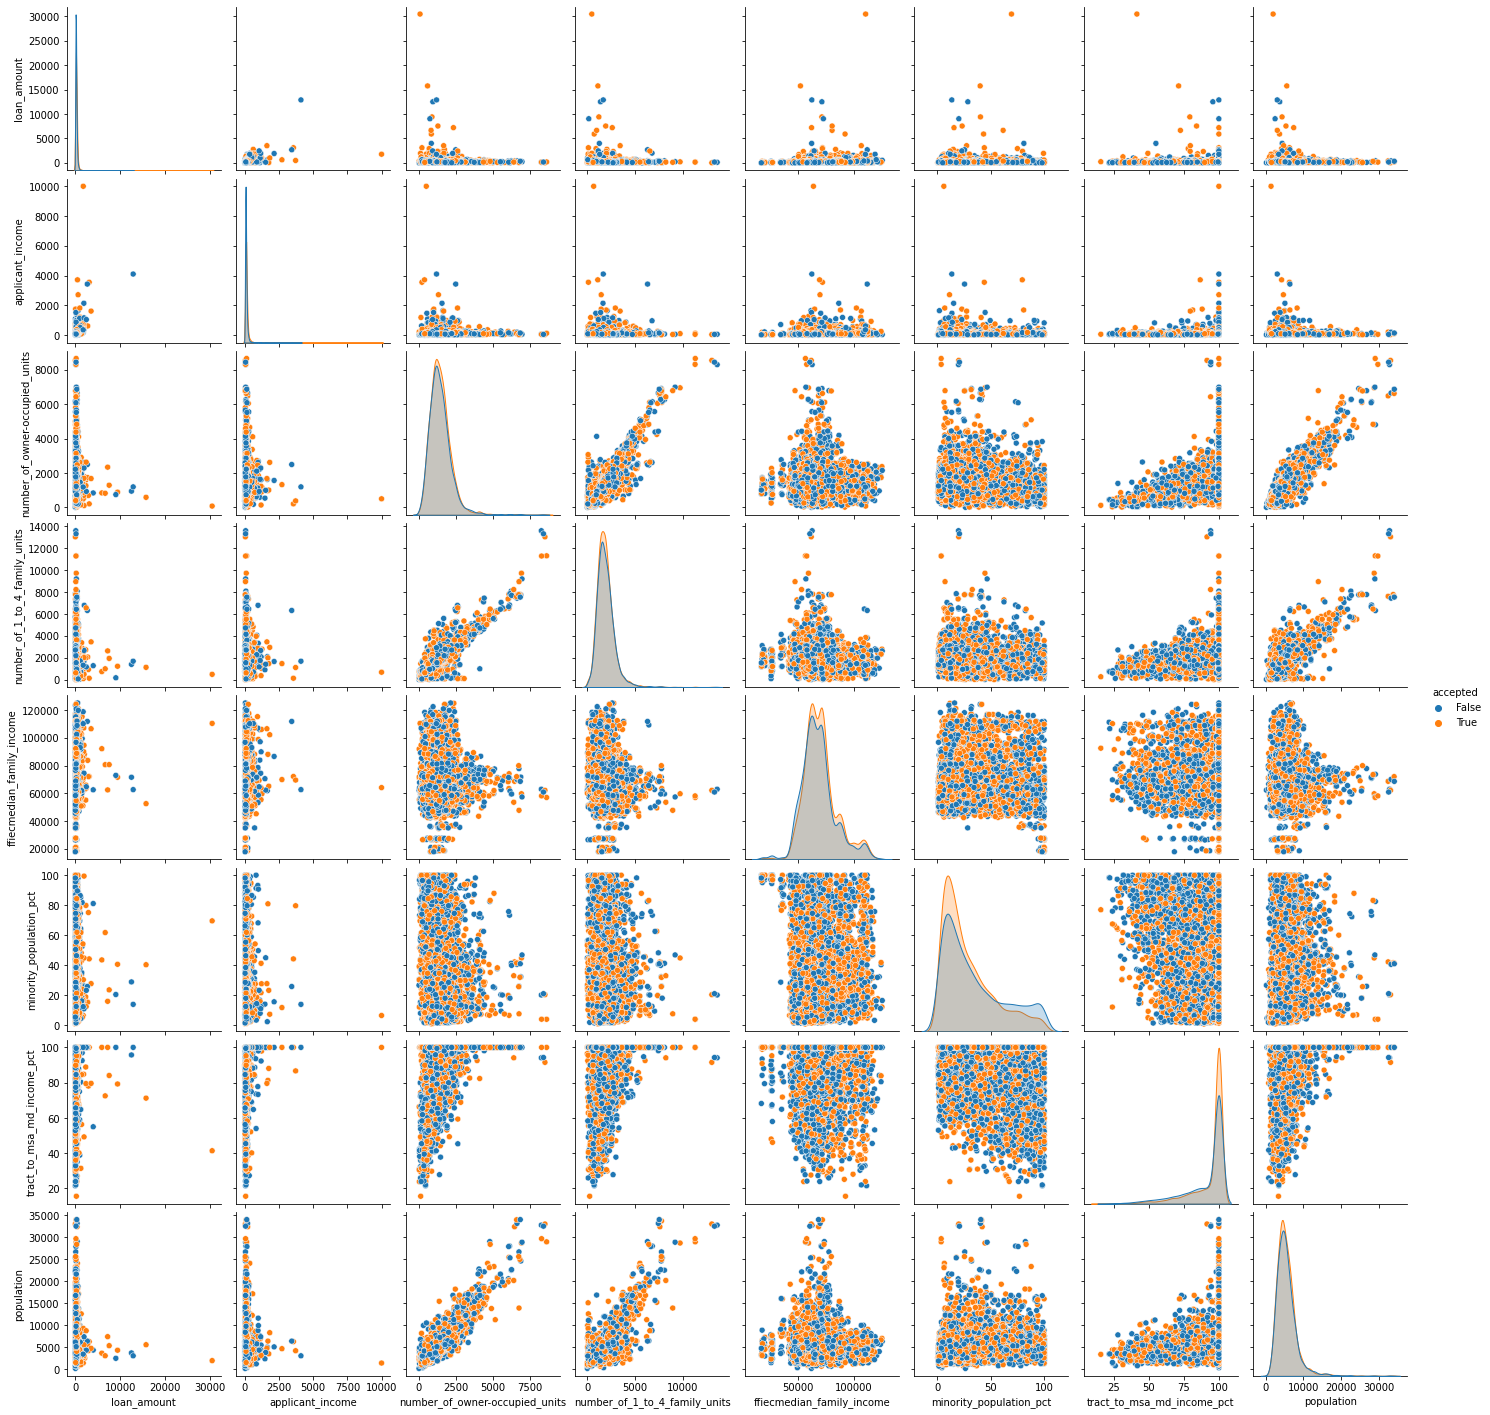

In [20]:
sample_data = data.sample(10000)
sns.pairplot(sample_data,vars=cols_numerical, hue='accepted');

The pairplot confirms the extreme values for loan_amount and applicant income. In some cases, there seem to be a linear relationship. Any correlation can be quickly check using the heatmap.

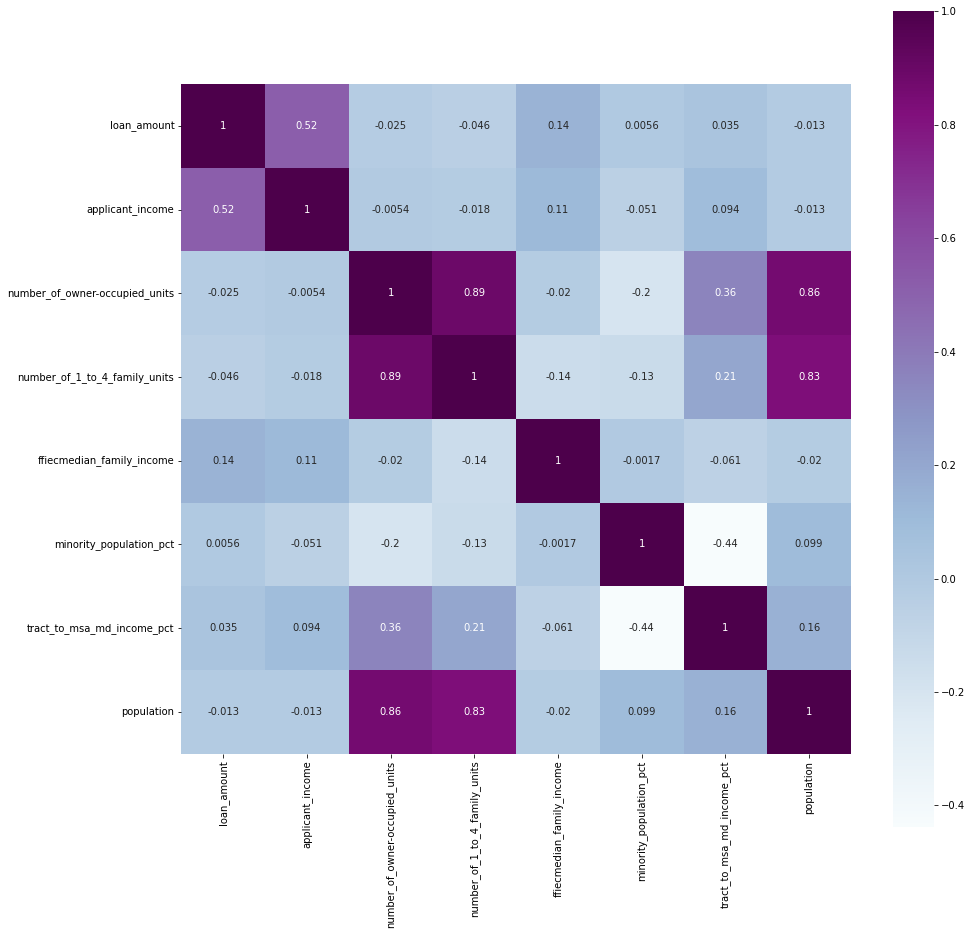

In [23]:
fix, ax = plt.subplots(figsize=(15,15))
sns.heatmap(sample_data[cols_numerical].corr(), annot=True, square=True, cmap='BuPu', ax=ax)
plt.show()

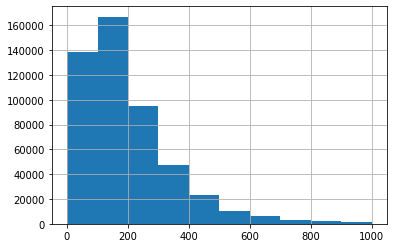

In [24]:
train_data[train_data['loan_amount']<1000]['loan_amount'].hist();

### Explore the correlated numerical features

It seems that there are some numerical features, which are corelated with each other. This correlation can be explored for fitting the missing data.

The data also shows, that features such as 'loan_amount' have a very narrow distribution with a long tail. To speed up the analysis, let's take a sample of our data - 10000 data points and convert this into the logarithmic scale. 

In [25]:
data[['log_loan_amount']] = data[['loan_amount']].applymap(math.log)

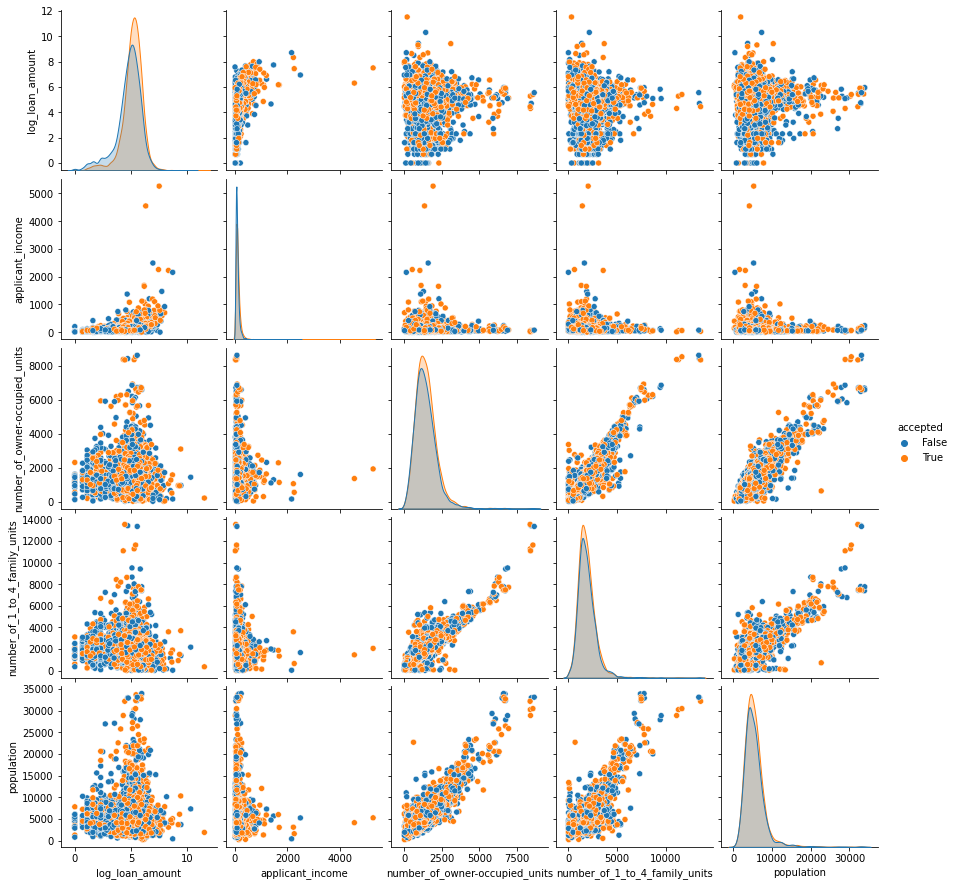

In [26]:
sample_data = data.sample(10000)

sns.pairplot(sample_data, vars=['log_loan_amount', 
                                'applicant_income', 
                                'number_of_owner-occupied_units', 
                                'number_of_1_to_4_family_units',
                                'population'], hue='accepted')
plt.show()

### Explore categorical variables

In [ ]:
def BoxPlots(data, columns, ref = ['accepted'], hue='accepted', logY=False):
    for column in columns:
        for r in ref:
            fig, ax = plt.subplots(figsize=(11.7,8.27))
            if logY:
                ax.set(yscale="log")
            sns.boxplot(x=r, ax=ax, y=column, data=data, hue=hue)
            plt.xlabel(r)
            plt.ylabel(column)
            plt.show()
    return ax

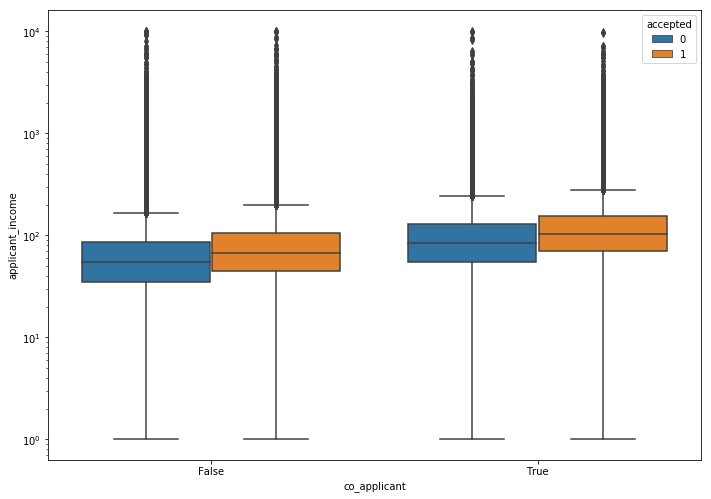

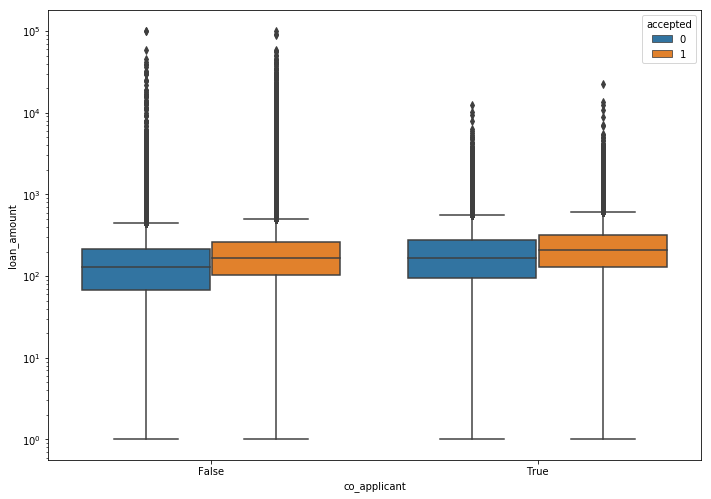

In [137]:
ax = BoxPlots(data, ['applicant_income', 'loan_amount'], ref = ['co_applicant'], hue = 'accepted', logY=True)


In [ ]:
def CatPlots(data, cols, ref='accepted'):
    '''
    Plot categorical data from the DataFrame 'data' using the columns in cols.
    Split the categorical data in line with a label reference
    '''
    for col in cols:
        print(col)
        fig, ax = plt.subplots(figsize=(15,5))
        sns.countplot(x=col, data=data, hue=ref, ax=ax)
        #plt.tick_params(
        #    axis='x',          # changes apply to the x-axis
        #    which='both',      # both major and minor ticks are affected
        #    bottom=False,      # ticks along the bottom edge are off
        #    top=False,         # ticks along the top edge are off
        #    labelbottom=False) # labels along the bottom edge are off
        #ax.set_xticklabels([])
        plt.show()

loan_type


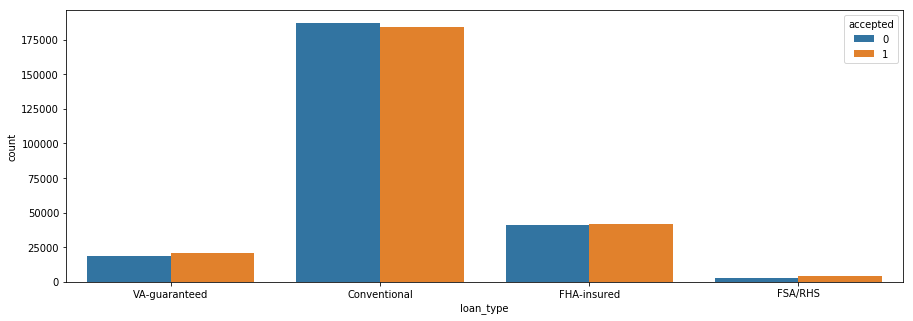

property_type


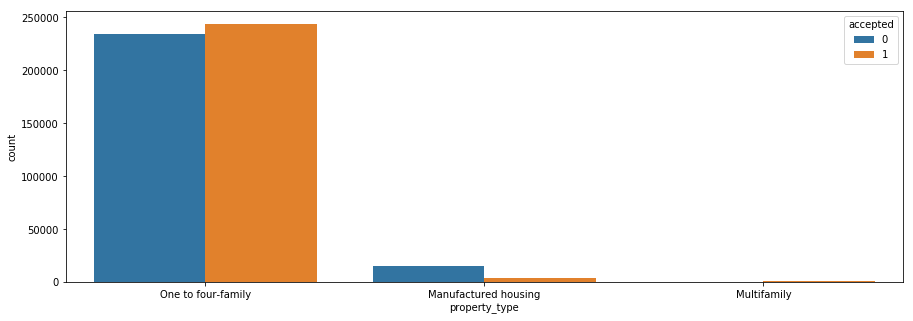

loan_purpose


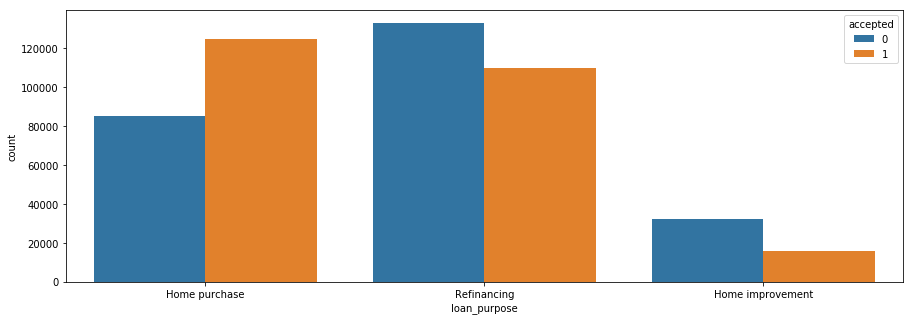

occupancy


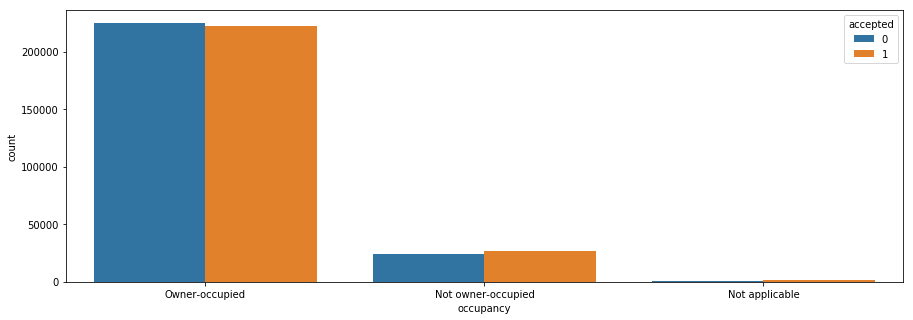

preapproval


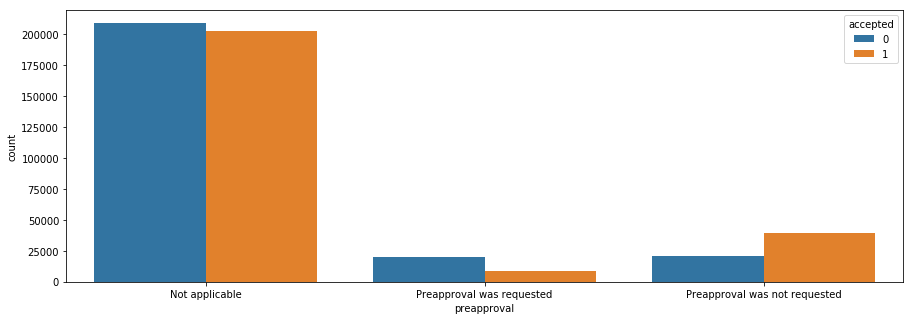

applicant_ethnicity


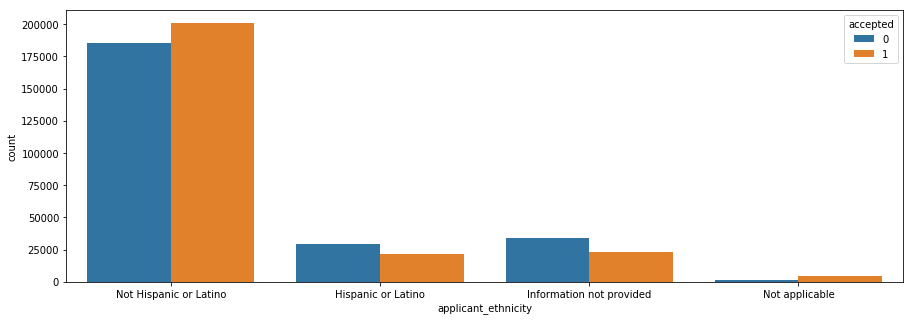

applicant_race


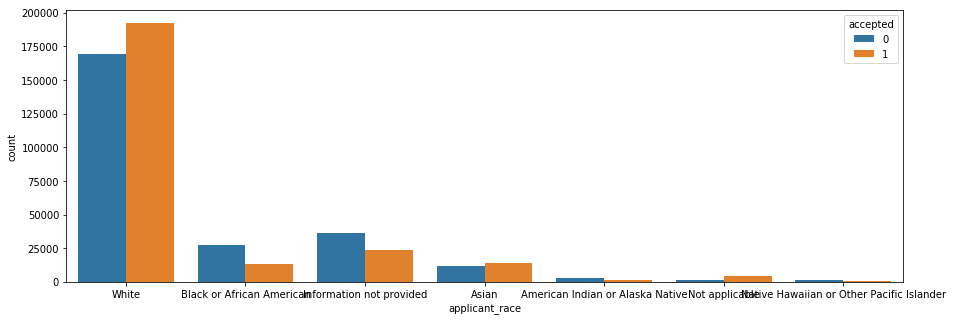

applicant_sex


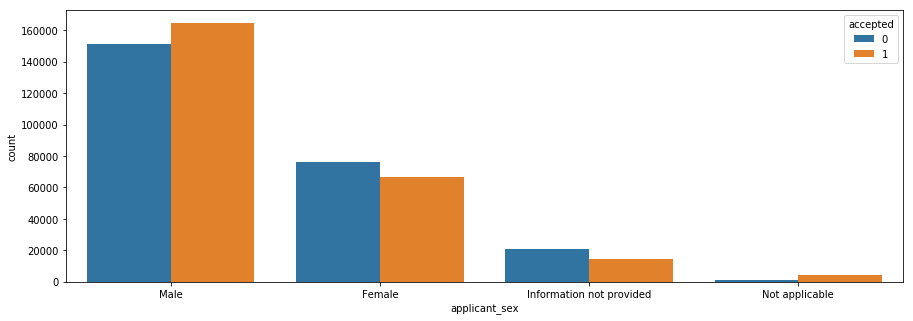

co_applicant


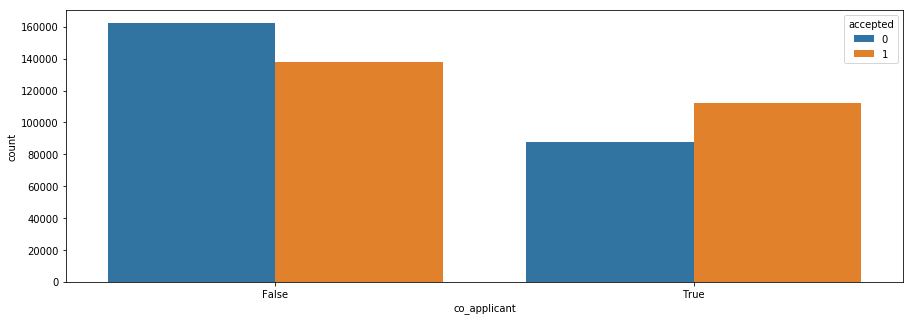

In [99]:
CatPlots(data, cols_categorical)

In [67]:
print('Applicant_sex = 1 - average acceptance:', data[data['applicant_sex']==1]['accepted'].mean())
print('Applicant_sex = 2 - average acceptance:', data[data['applicant_sex']==2]['accepted'].mean())
print('Applicant ethnicity = 4 - average acceptance:', data[data['applicant_ethnicity']==4]['accepted'].mean())
print('Applicant ethnicity = 1 - average acceptance:', data[data['applicant_ethnicity']==1]['accepted'].mean())

Applicant_sex = 1 - average acceptance: 0.520822910267696
Applicant_sex = 2 - average acceptance: 0.46645342814748453
Applicant ethnicity = 4 - average acceptance: 0.789310878157759
Applicant ethnicity = 1 - average acceptance: 0.427413324938019


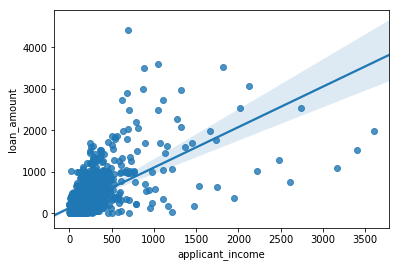

In [72]:
sns.regplot(data=data, x=data[data['state_code']==45]['applicant_income'],
                y=data[data['state_code']==45]['loan_amount'])

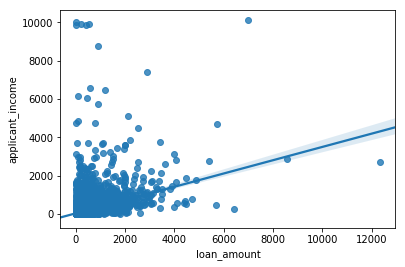

In [105]:
smpl = data.sample(100000)
sns.regplot(data=smpl, x=smpl['loan_amount'],
                y=smpl['applicant_income'])

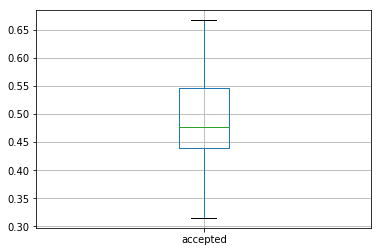

In [89]:
data[np.logical_and(data['state_code']==48, data['county_code']!=-1)].groupby('county_code').agg('mean').boxplot('accepted')

In [93]:
data[data['state_code'].isin([2,4])]['accepted'].mean()

0.4903343840236295

In [97]:
data[data['state_code'].isin([2,4])].groupby(['loan_type', 'state_code']).agg('mean')['accepted'].head(10)

loan_type  state_code
1          2             0.435804
           4             0.569992
2          2             0.503708
           4             0.554178
3          2             0.531802
           4             0.639456
4          2             0.461240
           4             0.617647
Name: accepted, dtype: float64

## Minority information

In [ ]:
race = ['applicant_race', {1: 'American Indian or Alaska Native',
                             2: 'Asian',
                             3: 'Black or African American',
                             4: 'Native Hawaiian or Other Pacific Islander',
                             5: 'White',
                             6: 'Information not provided',
                             7: 'Not applicable',
                             8: 'No co-applicant'}]



In [9]:
data['is_minority'] = data['applicant_race'].apply(lambda x: 0 if x=='White' else 1)

is_minority


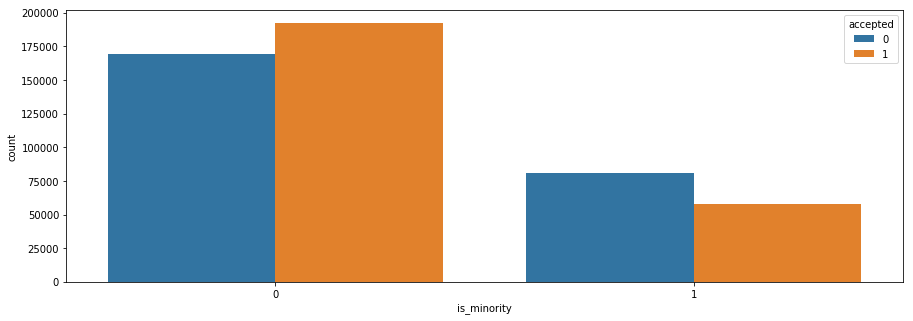

In [10]:
CatPlots(data, ['is_minority'])

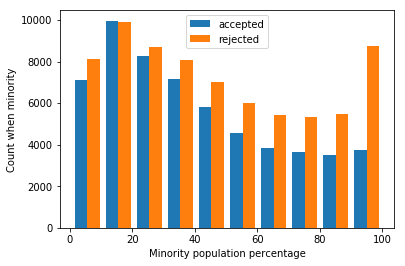

In [43]:
smpl = data[data['minority_population_pct'].notna()]

plt.hist([smpl.loc[np.logical_and(smpl['accepted']==1, smpl['is_minority']==1), ['minority_population_pct']].values,
          smpl.loc[np.logical_and(smpl['accepted']==0, smpl['is_minority']==1), ['minority_population_pct']].values],
         
                  label=['accepted', 'rejected']
                 )
#sns.distplot(smpl.loc[np.logical_and(smpl['accepted']==0, smpl['is_minority']==1), ['minority_population_pct']], 
#             kde=False, hist_kws={'label':'rejected'})
plt.xlabel('Minority population percentage')
plt.ylabel('Count when minority')
plt.legend()
plt.show()

## Property location analysis

First let's look at the missing data:

In [145]:
for col in cols_property_location:
    if data[col].dtype != object:
        count = 0
        count = [count + 1 for x in data[col] if x == -1]
        print (col + ' ' + str(sum(count)))

msa_md 76982
state_code 19132
county_code 20466


In [160]:
for col in cols_numerical:
    print(col, data[np.logical_and(data['state_code']==-1, data[col].isna())].shape[0])

loan_amount 0
applicant_income 704
number_of_owner-occupied_units 19132
number_of_1_to_4_family_units 19132
ffiecmedian_family_income 19132
minority_population_pct 19132
tract_to_msa_md_income_pct 19132
population 19132


In [164]:
a = data[np.logical_and(data['state_code']==-1, data['accepted']==1)].shape[0]
r = data[np.logical_and(data['state_code']==-1, data['accepted']==0)].shape[0]
print('Missing state_code and accepted', a)
print('Missing state_code and rejected', r)    
print('Reject probability when no state code provided', r/data[data['state_code']==-1].shape[0])

Missing state_code and accepted 542
Missing state_code and rejected 18590
Reject probability when no state code provided 0.9716704996863893


In [166]:
a = data[np.logical_and(data['county_code']==-1, data['accepted']==1)].shape[0]
r = data[np.logical_and(data['county_code']==-1, data['accepted']==0)].shape[0]
print('Missing county_code and accepted', a)
print('Missing county_code and rejected', r)    
print('Reject probability when no county code provided', r/data[data['county_code']==-1].shape[0])

Missing county_code and accepted 714
Missing county_code and rejected 19752
Reject probability when no county code provided 0.9651128701260627


state_code


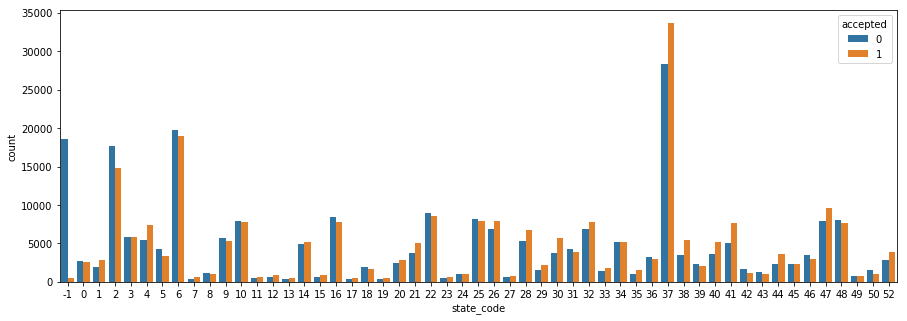

county_code


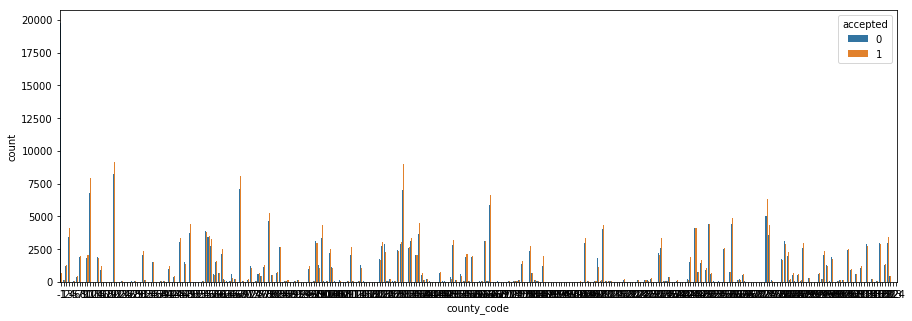

In [167]:
CatPlots(data, ['state_code', 'county_code'])

county_code


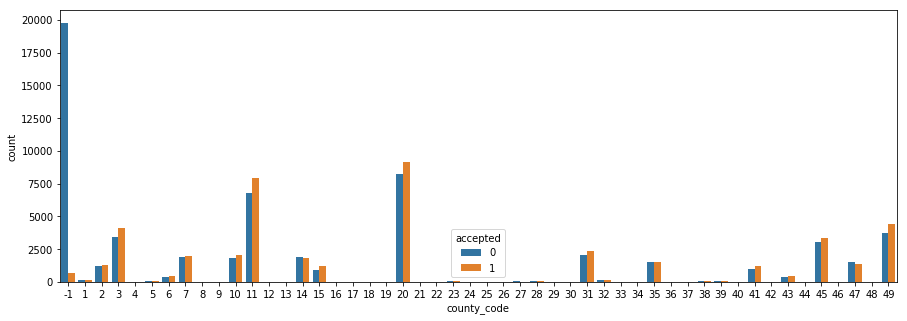

In [169]:
CatPlots(data[data['county_code']<50], ['county_code'])

Next, for the property location, let's check whether the state code is actually representing the state based on FIPS codes. The 2017 version of these codes can be found here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html.

In [64]:
fips = pd.read_excel('geocodes/state-geocodes-v2017.xlsx', sheet_name = "CODES14", header=5)
fips.head()

,Region,Division,State (FIPS),Name
0,1,0,0,Northeast Region
1,1,1,0,New England Division
2,1,1,9,Connecticut
3,1,1,23,Maine
4,1,1,25,Massachusetts


The states are attributed also to US regions and divisions. This information may be useful to lower the the number of categories in the state code column. Before that, let's explore the state codes column, whether there are any directly visible issues.

In [65]:
data['state_code'].value_counts().sort_index()

-1     19132
 0      5230
 1      4716
 2     32509
 3     11648
 4     12858
 5      7614
 6     38712
 7      1016
 8      2089
 9     10923
 10    15732
 11     1128
 12     1579
 13      895
 14    10183
 15     1521
 16    16133
 17      932
 18     3587
 19      843
 20     5269
 21     8846
 22    17476
 23     1094
 24     2074
 25    16087
 26    14776
 27     1497
 28    12069
 29     3720
 30     9503
 31     8132
 32    14563
 33     3215
 34    10367
 35     2657
 36     6228
 37    61967
 38     8960
 39     4372
 40     8859
 41    12807
 42     2903
 43     2209
 44     5986
 45     4638
 46     6506
 47    17447
 48    15761
 49     1620
 50     2591
 52     6821
Name: state_code, dtype: int64

What is apparent, that apart from values -1 which indicate missing values, we also see 5230 instances of the value being 0. As we do not have state codes beyound 52, the value 0 may indicate all other territories associated with US. Let's recode 0 to be another negative number such as -2 to help with the merge with state names dataset. There are no values above 52, which makes it interesting, as 53 is Washington, 54, West Virginia, etc.. There is a strong possibility that the state codes do not have any asociation with FIPS codes, or simply the dataset simply omits the information from these states.

Additionally, there are currently no state codes 3, 7, 14, 43, 52. These numbers are FIPS reserved codes (https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code), and are ommited from FIPS PUB 5-2 standard. However as it is not clear from which this dataset is, these codes were probably used. From the link above the numbers are as follows:
-  3: American Samoa:
-  7: Canal Zone - former teritory of the US at the Panama canal
-  14: Guam
-  43: Puerto Rico
-  52: Virgin Islands of the US

Probably all these could be clasified as "Outlying area under U.S. sovereignty".

But let's first check the number of rows which have a state_code in from the [0, 3, 7, 14, 43, 53], while at the same time have the msa_md information. This would also show whether the state code can be considered reliable.

In [73]:
data[data['state_code'].isin([0, 3, 7, 14, 43, 53]) & (data['msa_md'] != -1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25597 entries, 22 to 499977
Data columns (total 22 columns):
loan_type                         25597 non-null object
property_type                     25597 non-null object
loan_purpose                      25597 non-null object
occupancy                         25597 non-null object
loan_amount                       25597 non-null float64
preapproval                       25597 non-null object
msa_md                            25597 non-null int64
state_code                        25597 non-null int64
county_code                       25597 non-null int64
applicant_ethnicity               25597 non-null object
applicant_race                    25597 non-null object
applicant_sex                     25597 non-null object
applicant_income                  23367 non-null float64
population                        25589 non-null float64
minority_population_pct           25589 non-null float64
ffiecmedian_family_income         25589 non-null

The dataset still contains around 25597 rows of data, which have seemingly an incorrect FIPS state code, but have a msa_md value. Puts the fact whether the state_codes and county codes are actually correct. Nevertheless let's proceed with the data analysis and merge the FIPS codes with the dataset, while changing the "0" state code to -2.

In [74]:
data.loc[data['state_code'].isin([0, 3, 7, 14, 43, 53]),'state_code'] = -2

Now we should be able to proceed and add geography information to the training data. We need to use a left join as in the original dataset, we have 19132 state codes missing (indicated as -1) and 5230 state codes indicated as -2.
Afterwards, we can remove the column "State (FIPS)" from the merged dataframe, as it is a copy of the state_code column anyway.
Also, to aid the expolatory analysis later, let's add the Region and Division columns back to the list of columns defining property location. 

In the end, the dataset should be extended by 3 additional columns. We can also add the categorical columns to the cols_property_location list.

In [84]:
print(data.shape)
train_data_with_state = data.merge(fips, how = 'left', left_on='state_code', right_on="State (FIPS)")
train_data_with_state.drop('State (FIPS)', axis = 1, inplace=True)
print(train_data_with_state.shape)

(500000, 23)
(500000, 26)


In [85]:
cols_property_location.extend(['Region', 'Division'])

In [86]:
train_data_with_state.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted,log_loan_amount,Region,Division,Name
0,VA-guaranteed,One to four-family,Home purchase,Owner-occupied,70.0,Not applicable,18,37,246,Not Hispanic or Latino,...,50.933,716.0,2642.0,4536,False,1,4.248495,3.0,5.0,North Carolina
1,Conventional,One to four-family,Refinancing,Owner-occupied,178.0,Not applicable,369,52,299,Hispanic or Latino,...,100.000,1622.0,2108.0,2458,False,0,5.181784,NaN,NaN,NaN
2,FHA-insured,One to four-family,Refinancing,Owner-occupied,163.0,Not applicable,16,10,306,Not Hispanic or Latino,...,100.000,760.0,1048.0,5710,False,1,5.093750,3.0,5.0,Delaware
3,Conventional,One to four-family,Home purchase,Owner-occupied,155.0,Preapproval was requested,305,47,180,Not Hispanic or Latino,...,100.000,2025.0,2299.0,5888,True,1,5.043425,3.0,6.0,Tennessee
4,Conventional,One to four-family,Home purchase,Owner-occupied,305.0,Not applicable,24,37,20,Not Hispanic or Latino,...,82.200,1464.0,1847.0,289,False,1,5.720312,3.0,5.0,North Carolina


### Explore the state and county info

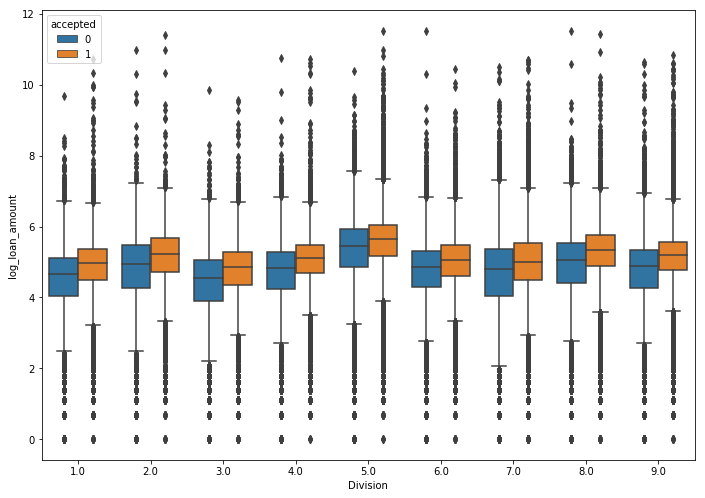

In [90]:
BoxPlots(train_data_with_state, ['log_loan_amount'], ref=['Division'])

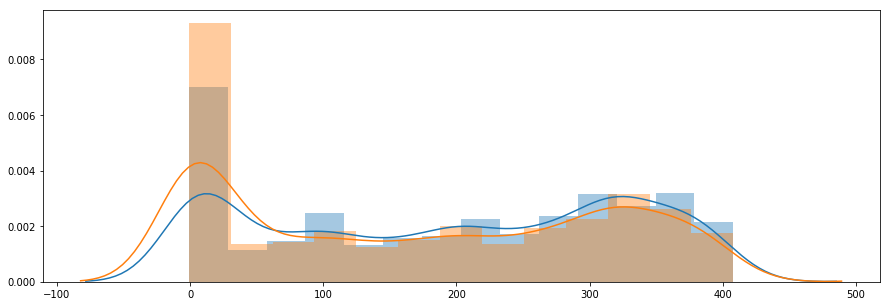

In [139]:
sample_data = data.sample(10000)
fig, ax = plt.subplots(figsize = (15,5))
ax = sns.distplot(sample_data.loc[sample_data['accepted']==1, ['msa_md']], ax=ax)
sns.distplot(sample_data.loc[sample_data['accepted']==0, ['msa_md']], ax=ax)
plt.show()

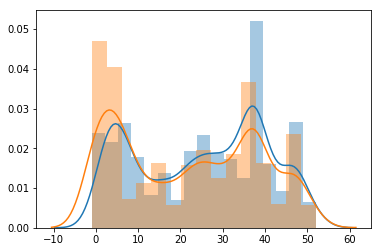

In [140]:
ax = sns.distplot(sample_data.loc[sample_data['accepted']==1, ['state_code']])
sns.distplot(sample_data.loc[sample_data['accepted']==0, ['state_code']], ax=ax)
plt.show()

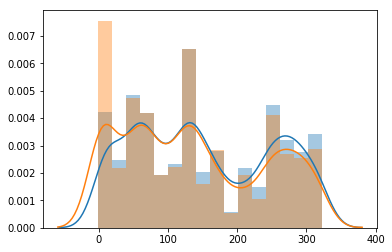

In [141]:
ax = sns.distplot(sample_data.loc[sample_data['accepted']==1, ['county_code']])
sns.distplot(sample_data.loc[sample_data['accepted']==0, ['county_code']], ax=ax)
plt.show()

In [12]:
data[cols_categorical] = data[cols_categorical].astype('category')
data[cols_property_location] = data[cols_property_location].astype('category')
#data['co_applicant', 'accepted'] = data['co_applicant', 'accepted'].astype('bool')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 23 columns):
loan_type                         500000 non-null category
property_type                     500000 non-null category
loan_purpose                      500000 non-null category
occupancy                         500000 non-null category
loan_amount                       500000 non-null float64
preapproval                       500000 non-null category
msa_md                            500000 non-null category
state_code                        500000 non-null category
county_code                       500000 non-null category
applicant_ethnicity               500000 non-null category
applicant_race                    500000 non-null category
applicant_sex                     500000 non-null category
applicant_income                  460052 non-null float64
population                        477535 non-null float64
minority_population_pct           477534 non-null float64
ffiecmed

In [77]:
train_data_with_state['msa_md'].value_counts().sort_index(ascending=True)

-1      76982
 0        353
 1       1462
 2        422
 3        188
 4        153
 5        224
 6       2135
 7        173
 8        148
 9        347
 10      4597
 11       494
 12       261
 13       710
 14       151
 15       358
 16      4614
 17       798
 18      8466
 19      1196
 20       550
 21       823
 22       807
 23       133
 24     12993
 25      7409
 26       270
 27      1598
 28       104
        ...  
 379      532
 380      342
 381      497
 382     1076
 383     2906
 384      301
 385     3444
 386      260
 387     1094
 388      286
 389     1518
 390      365
 391      439
 392      890
 393      375
 394      113
 395     5309
 396      178
 397     3123
 398     3577
 399      191
 400      237
 401      357
 402      157
 403      755
 404      193
 405      120
 406      110
 407      187
 408      380
Name: msa_md, Length: 409, dtype: int64

Despite of the fact that it looks like the state and county information is not in line with FIPS, let's look at what is the probability that for a certain state and county a mortgage application will be accepted.

First we need to create a combined column with state code and county code.
Note: if during import the county_code 020 is converted to int 20, we may need to take care of this. We also need to make sure we won't create state_county codes such as -1-1, as that makes no sense.

In [ ]:
data['state_county'] = data['state_code'].map(str) + data['county_code'].map(str)
data.head()

In [6]:
state_county_classification = pd.DataFrame(data['state_county'].unique(), columns=['state_county'])

counts_accepted = data.loc[data['accepted'] == 1, 'state_county'].value_counts()
counts_rejected = data.loc[data['accepted'] == 0, 'state_county'].value_counts()

def AcceptRatio(lender, accept, reject):
    total = 0.0
    acc = 0.0
    if lender in accept:
        total += accept[lender]
        acc = accept[lender]
    if lender in reject:
        total += reject[lender]
    if total > 0:
        return float(acc)/float(total)
    else:
        return np.NaN

state_county_classification['accept_rate'] = state_county_classification['state_county'].apply(AcceptRatio, args=[counts_accepted, counts_rejected])

state_county_classification = state_county_classification.set_index('state_county')
state_county_classification.head()

KeyError: 'state_county'

In [ ]:
def DistPlots(data, columns):
    for column in columns:
        fig, ax = plt.subplots(figsize=(11.7,8.27))
        ax = sns.distplot(data[column], ax=ax)
        plt.xlabel('value')
        plt.ylabel('density')
        plt.title('Histogram of ' + column)
        plt.show()

In [ ]:
DistPlots(state_county_classification, ['accept_rate'])

It is interesting to see, that while the average value of acceptance rate seems to be around 0.5, there seem to be state county combinations where all the mortgage applications are accepted or rejected.

Let's save the datafile for later use.

Update: experimentally it has not shown that this information actually provides additional accuracy to the model.

In [ ]:
state_county_classification.to_csv('output/state_county_classification.csv')

In [ ]:
state_county_classification.info()

In [ ]:
data['state_county_classification'] = data['state_county'].apply(lambda x: state_county_classification.loc[x, 'accept_rate'])

## Lender column analysis

Let's analyse the lender column by first looking at the number of different lenders and the number of the applications they have been considering.

In [114]:
print(train_data['lender'].unique().shape)
train_data['lender'].value_counts()

(6111,)


6240    31685
5710    25125
3354    20450
5726    12281
2458    11692
4701    10858
2839    10131
5316     9405
4398     6353
2570     5608
882      5183
4129     4782
2318     4635
6446     4434
969      4380
3791     4264
3233     4021
878      3860
3497     3560
5026     3471
1928     3405
3507     3362
5154     3126
1574     2970
2833     2577
6451     2562
684      2441
3896     2410
4442     2337
2560     2278
        ...  
103         1
6500        1
2406        1
1639        1
5989        1
3942        1
104         1
4715        1
1129        1
6505        1
613         1
101         1
2657        1
1892        1
5731        1
4448        1
4704        1
3171        1
3427        1
1634        1
3939        1
4193        1
3682        1
5985        1
1891        1
2149        1
6247        1
2917        1
3685        1
0           1
Name: lender, Length: 6111, dtype: int64

There are 6111 unique lenders and we see that there is one with the value 0, there are several lenders with only a single record and the highest number of applications is 31685.

Let's try and classify lenders based on the number of loans they have been dealing with. Real world datasets won't have the result of the loan acceptance.

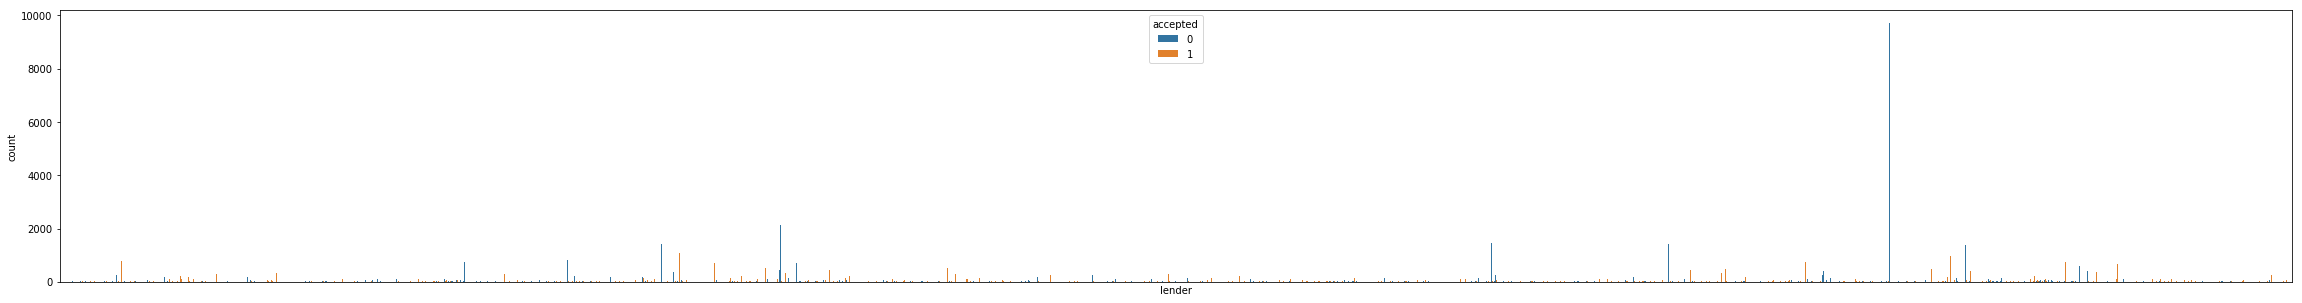

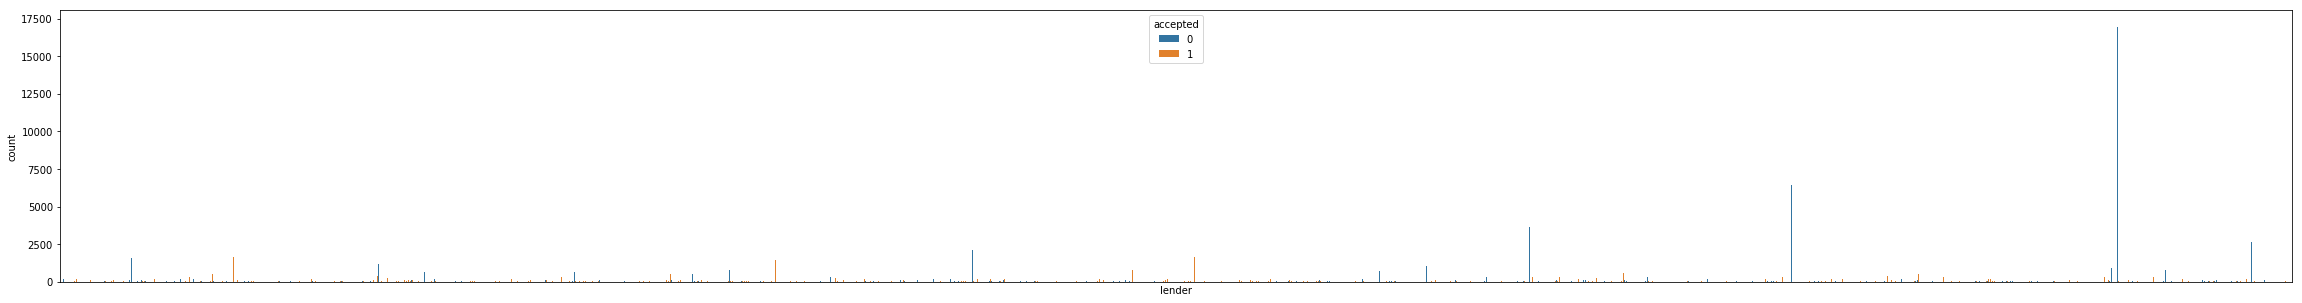

In [46]:
#CategoricalPlots(train_data_with_state, ['lender'])
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(x='lender', data=data[data['lender']<3000], hue='accepted', ax=ax)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#ax.set_xticklabels([])
plt.show()
fig2, ax2 = plt.subplots(figsize=(40,5))
sns.countplot(x='lender', data=data[data['lender']>=3000], hue='accepted', ax=ax2)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

We see that some lednders are more often accepting, some are more often rejecting the application. So probably we need to look at whether we can clasify lenders with a threshold depending on how many applications were rejected or accepted by a particular lender historically.

In [15]:
lender_classification = pd.DataFrame(data['lender'].unique(), columns=['lender'])

counts_accepted = data.loc[data['accepted'] == 1, 'lender'].value_counts()
counts_rejected = data.loc[data['accepted'] == 0, 'lender'].value_counts()

def AcceptRatio(lender, accept, reject):
    total = 0.0
    acc = 0.0
    if lender in accept:
        total += accept[lender]
        acc = accept[lender]
    if lender in reject:
        total += reject[lender]
    if total > 0:
        return float(acc)/float(total)
    else:
        return np.NaN

lender_classification['accept_rate'] = lender_classification['lender'].apply(AcceptRatio, args=[counts_accepted, counts_rejected])

lender_classification = lender_classification.set_index('lender')

lender_classification.head()

,accept_rate
lender,
4536,0.837209
2458,0.168919
5710,0.489632
5888,0.691964
289,0.542994


In [ ]:
lender_classification.to_csv('output/lender_classification.csv')

In [ ]:
DistPlots(lender_classification, ['accept_rate'])

In [16]:
data['lender_classification'] = data['lender'].apply(lambda x: lender_classification.loc[x, 'accept_rate'])
data.head()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,...,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted,lender_classification
row_id,,,,,,,,,,,,,,,,,,,,,
0,3,1,1,1,70.0,3,18,37,246,2,...,6203.0,44.230,60588.0,50.933,716.0,2642.0,4536,False,1,0.837209
1,1,1,3,1,178.0,3,369,52,299,1,...,5774.0,15.905,54821.0,100.000,1622.0,2108.0,2458,False,0,0.168919
2,2,1,3,1,163.0,3,16,10,306,2,...,6094.0,61.270,67719.0,100.000,760.0,1048.0,5710,False,1,0.489632
3,1,1,1,1,155.0,1,305,47,180,2,...,6667.0,6.246,78439.0,100.000,2025.0,2299.0,5888,True,1,0.691964
4,1,1,1,1,305.0,3,24,37,20,2,...,6732.0,100.000,63075.0,82.200,1464.0,1847.0,289,False,1,0.542994


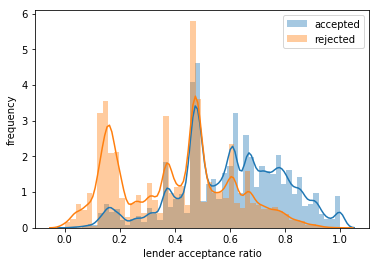

In [48]:
ax = sns.distplot(data.loc[data['accepted']==1, ['lender_classification']], hist_kws={'label':'accepted'})
sns.distplot(data.loc[data['accepted']==0, ['lender_classification']], ax=ax, hist_kws={'label':'rejected'})
plt.xlabel('lender acceptance ratio')
plt.ylabel('frequency')
plt.legend()
plt.show()

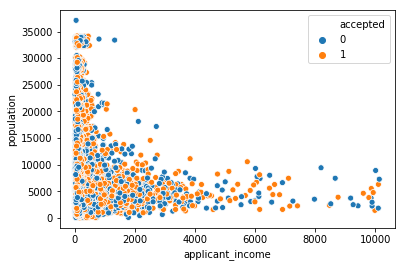

In [11]:
sns.scatterplot(data=data.loc[data['ffiecmedian_family_income'].notna(),['applicant_income', 
                                                    'population', 'accepted']], x='applicant_income',
                y='population',
                hue='accepted')

## Correlation between Lender and State_county classification

Let's evaluate a simple graphical correlation between the acceptance rate of the lenders and the properly location in the state_county combination:

In [ ]:
sample = data.sample(n=10000)
fig, ax = plt.subplots(figsize=(16,7))
sns.scatterplot(x=sample['lender_classification'], y='state_county_classification', data=sample, ax=ax)

plt.show()

In [ ]:
counts = train_data['lender'].value_counts()

def ClassifyLender(lender, s):
    if s[lender] < 100:
        return 'small'
    elif s[lender]>=100 and s[lender]<3000:
        return 'medium'
    elif s[lender]>=3000 and s[lender]<12000:
        return 'large'
    else:
        return 'huge'

train_data['lender_size'] = train_data['lender'].apply(ClassifyLender, args=[counts])
train_data['lender_size'].value_counts()

In [ ]:
train_data.head(20)

## Correlation between lender and numerical columns

In [ ]:
cols_to_log =  ['loan_amount','applicant_income', 'ffiecmedian_family_income','number_of_owner-occupied_units', 'number_of_1_to_4_family_units', 'population']
log_cols_numerical = ['log_' + x for x in cols_to_log]
print(log_cols_numerical)

data[log_cols_numerical] = data[cols_to_log].applymap(math.log)

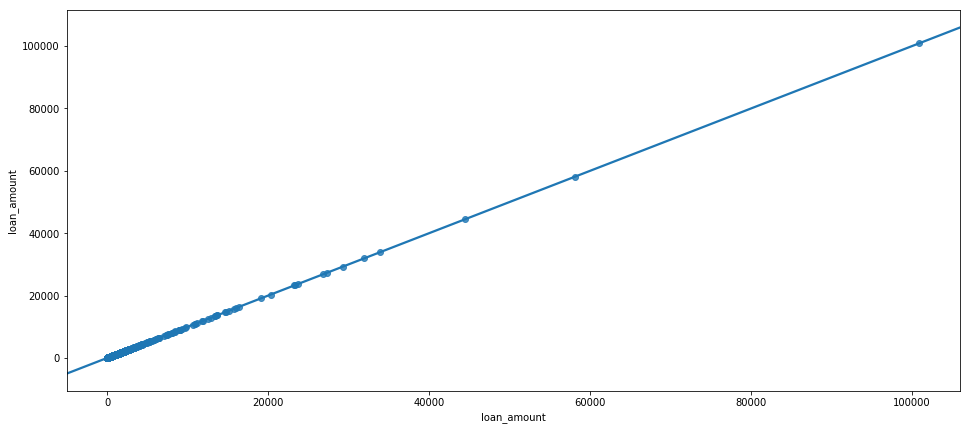

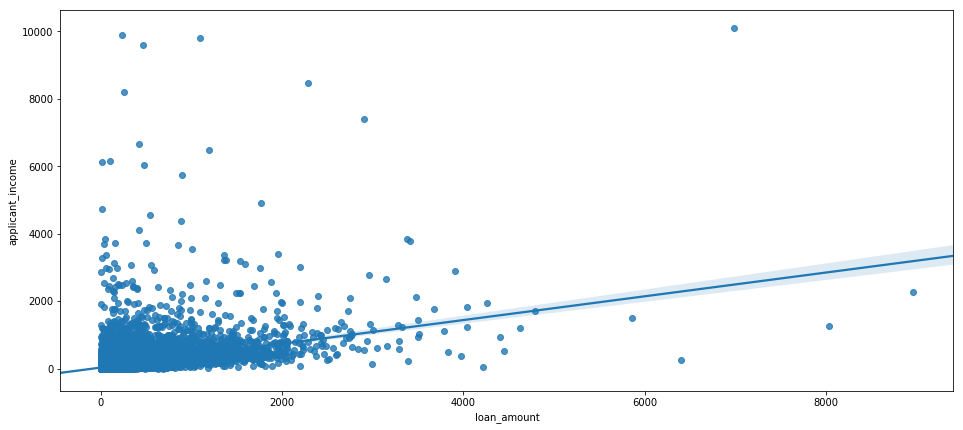

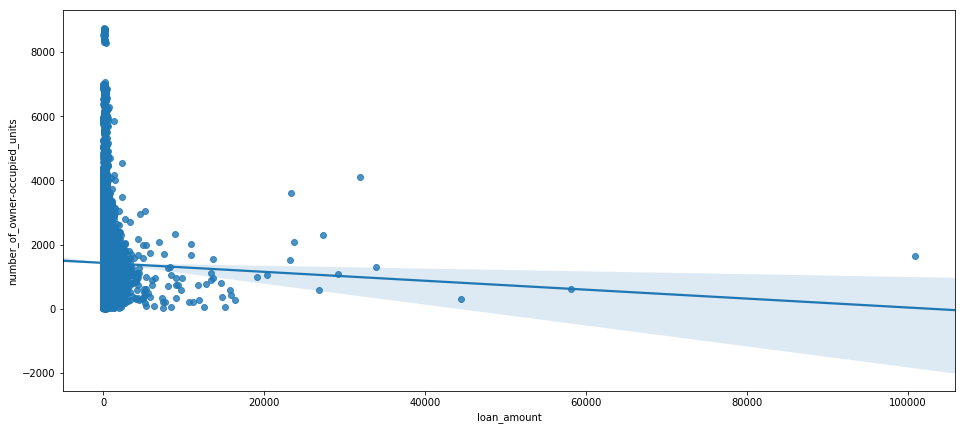

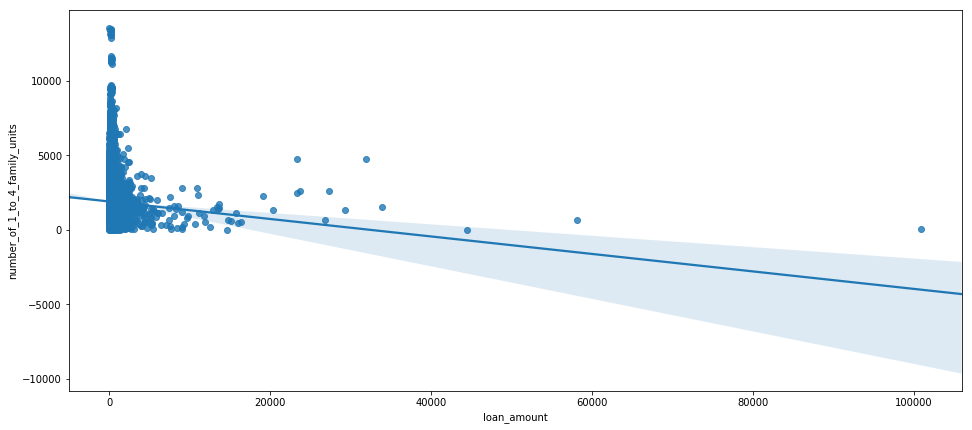

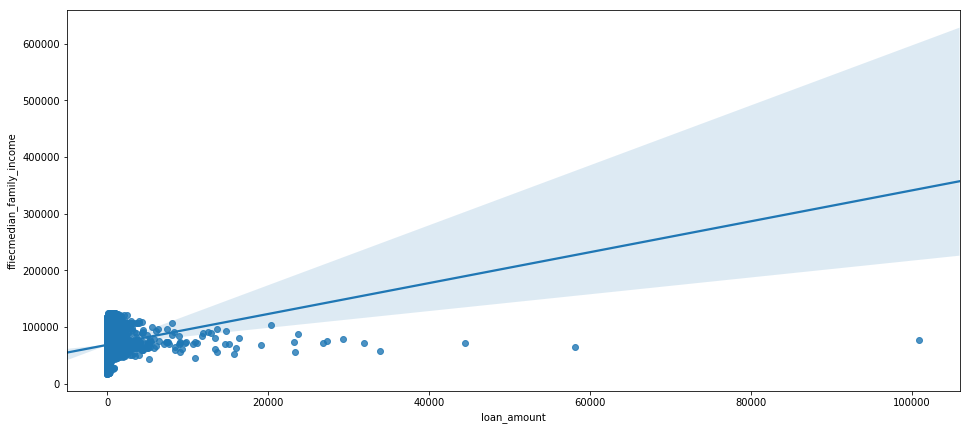

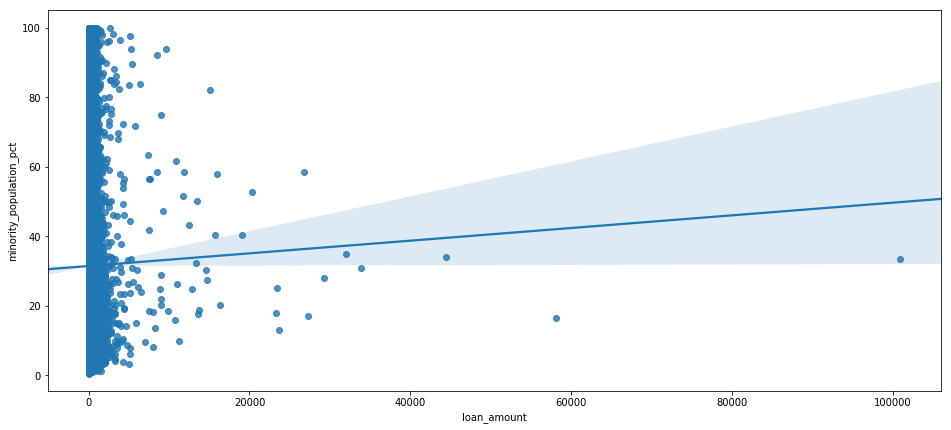

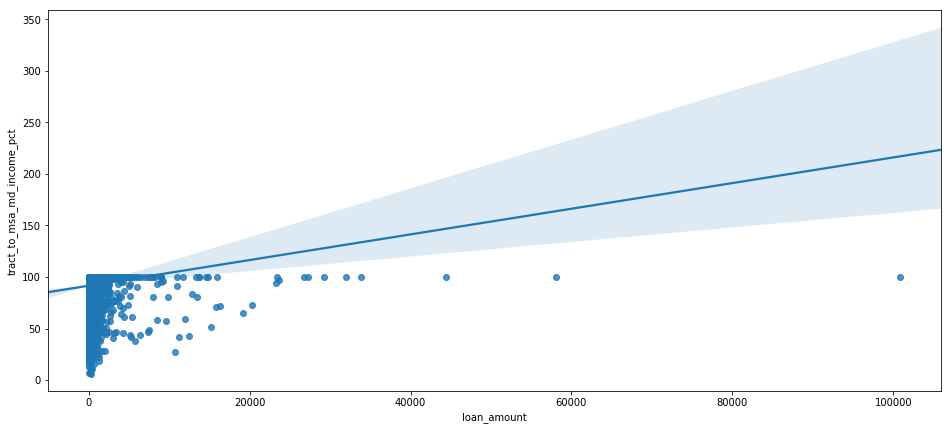

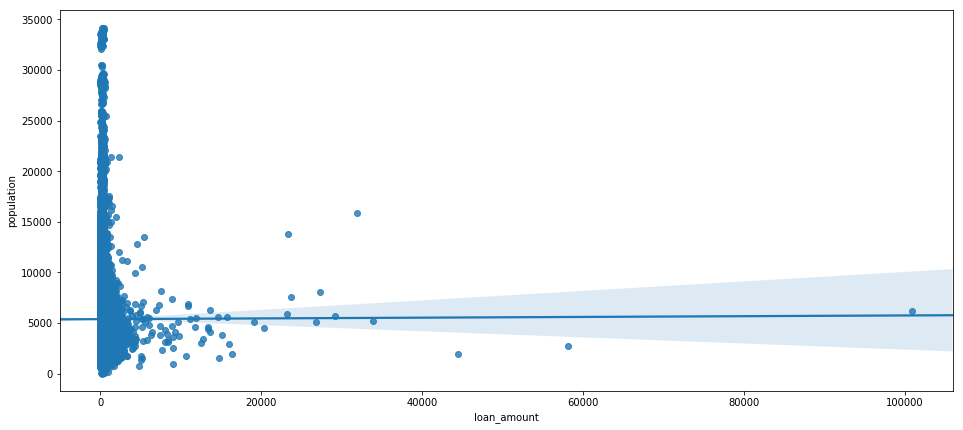

In [22]:
sample = data.sample(n=100000)
for col in cols_numerical:
    fig, ax = plt.subplots(figsize=(16,7))
    sns.regplot(x=sample['loan_amount'], y=col, data=sample, ax=ax)
    plt.show()

In [29]:
from sklearn import linear_model
from sklearn import metrics

regr = linear_model.LinearRegression()
regr_data = data.loc[data['applicant_income'].notna(),['loan_amount', 'applicant_income']]

regr_result = regr.fit(regr_data['loan_amount'].values.reshape(-1,1), regr_data['applicant_income'].values.reshape(-1,1))

regr_data['income_predict'] = regr_result.predict(regr_data['loan_amount'].values.reshape(-1,1))
print(regr_result.intercept_, regr_result.coef_)

#sns.regplot(x='loan_amount', y='income_predict', data=regr_data)

print(metrics.r2_score(regr_data['applicant_income'].values.reshape(-1,1), regr_data['income_predict'].values.reshape(-1,1)))

[30.29649863] [[0.34580343]]
0.2342082451035925


So the intercept for the relation between the loan_amount and application_income is 30.29 and the coefficient is 0.3458.

In [ ]:
BoxPlots(data, ['log_applicant_income'], ref=['state_code'])

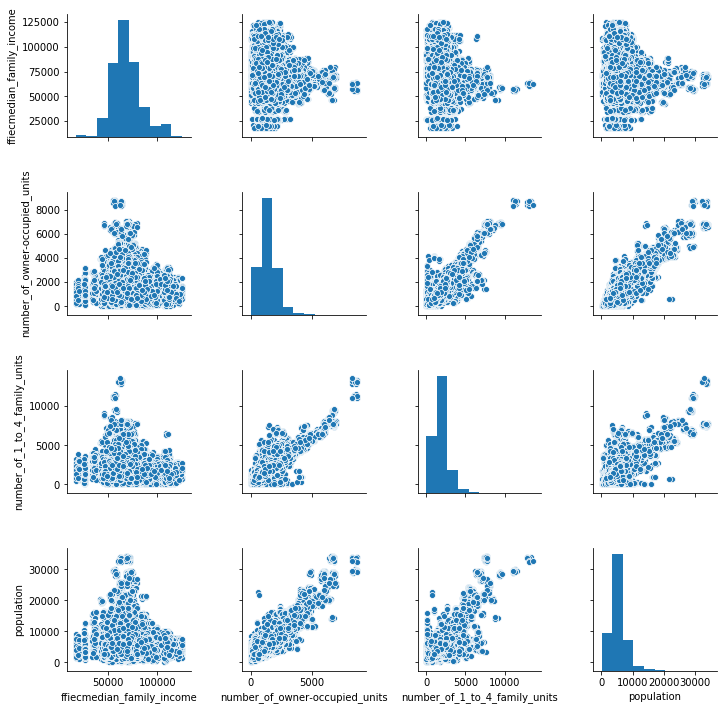

In [23]:
sample = data.sample(n=100000)

sns.pairplot(sample, vars=['ffiecmedian_family_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units','population'])

## Missing values



In [ ]:
cols_missing_values = cols_numerical.copy()
cols_missing_values.remove('loan_amount')

data[cols_missing_values].isna().sum()

In [ ]:
rows_with_na = data[data[cols_missing_values].isna().any(axis=1)]
rows_with_na[['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
             'ffiecmedian_family_income', 'minority_population_pct', 
              'tract_to_msa_md_income_pct','population']].isna().all(axis=1).sum()

Look at the rows in the dataset which have missing numerical values and merge it with the labels column to investigate how critical are the missing values.
Overall, there are 22440 rows of data where the complete set of cenzus data are missing. As this is very close to the individial counts of the missing data, there is probably additional value to include a boolean feature indicating that all data is missing.

In [ ]:
data['missing_census'] = data[['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                               'ffiecmedian_family_income', 'minority_population_pct', 
                               'tract_to_msa_md_income_pct','population']].isna().all(axis=1)

In [ ]:
data['missing_census'].value_counts()

In [ ]:
data.head(30)
#data.to_csv('train_data_with_missing_census.csv')

In [ ]:
rows_with_na = rows_with_na.merge(labels, on='row_id')
rows_with_na.head(30)

From the data above it seems that applicant_income data is missing, the other numerical features are present and vice versa. It also looks as if the missing numerical features have the label of "not accepted". So let's evaluate that theory.

First look at the situation when all the numerical features are missing:

In [ ]:
rows_with_na[rows_with_na[['applicant_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
             'ffiecmedian_family_income', 'minority_population_pct', 
              'tract_to_msa_md_income_pct','population']].isna().all(axis=1)]['accepted'].value_counts()

Even in case of all numerical information missing, there are still accepted and rejected loans, however there is a strong bias towards not acceptance.

Let's look at the situation when only 'applicant_income' information is missing.

In [ ]:
rows_with_na[rows_with_na['applicant_income'].isna()]['accepted'].value_counts()

Even with applicant income missing, the number of accepted and rejected loan applications is very similiar. In fact there is more applications accepted with the income information missing than rejected.

Let's look at the situation when applicant income is not missing, but other numerical features are not present:

In [ ]:
rows_with_na[(rows_with_na[['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
             'ffiecmedian_family_income', 'minority_population_pct', 
              'tract_to_msa_md_income_pct','population']].isna().all(axis=1)) &
             (rows_with_na['applicant_income'].notna())]['accepted'].value_counts()

In this case, most data show that the application has not been accepted in the data.

In [ ]:
rows_with_na[(rows_with_na[['number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
             'ffiecmedian_family_income', 'minority_population_pct', 
              'tract_to_msa_md_income_pct','population']].isna().all(axis=1)) &
             (rows_with_na['applicant_income'].notna())].head(20)

In [ ]:
if not('missing_census' in cols_categorical):
    cols_categorical.append('missing_census')

CategoricalPlots(data, cols_categorical, ref='missing_census')
#BoxPlots(data, cols_numerical, ref='missing_census')

In case the applicant income was not entered, there seem to be one particular lender not accepting such applications, and another lender accepting such applications.

Let's now change the categorical data into a human readable format to help further analysis. The mapping is based on the data guideline: https://datasciencecapstone.org/competitions/14/mortgage-approvals-from-government-data/page/44/

In [20]:
data['state_code']=data['state_code'].replace(to_replace=-1, value='XX')

In [21]:
data['county_code']=data['county_code'].replace(to_replace=-1, value='XX')

In [22]:
data['state_county'] = data['state_code'].map(str) + data['county_code'].map(str)

In [6]:
data.fillna(value=-1, inplace=True)

In [24]:
data2 = data.drop(['state_code', 'county_code'], axis=1)

The code below has been reused from the the following [link](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) as it allows for a fantastic visualization of associations.
TODO: link and reuse the code from [dython](https://github.com/shakedzy/dython) project.

In [ ]:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
import scipy.stats as ss
from collections import Counter
from matplotlib import pyplot as plt
from scipy import stats


def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'), cmap='coolwarm')
        plt.show()
    if return_results:
        return corr

In [7]:
cols_cat = ['loan_type', 'property_type', 'loan_purpose', 'occupancy', 'preapproval', 
                    'applicant_ethnicity', 'applicant_race', 'applicant_sex','co_applicant', 'msa_md', 
            'state_code', 'county_code' 
           ]

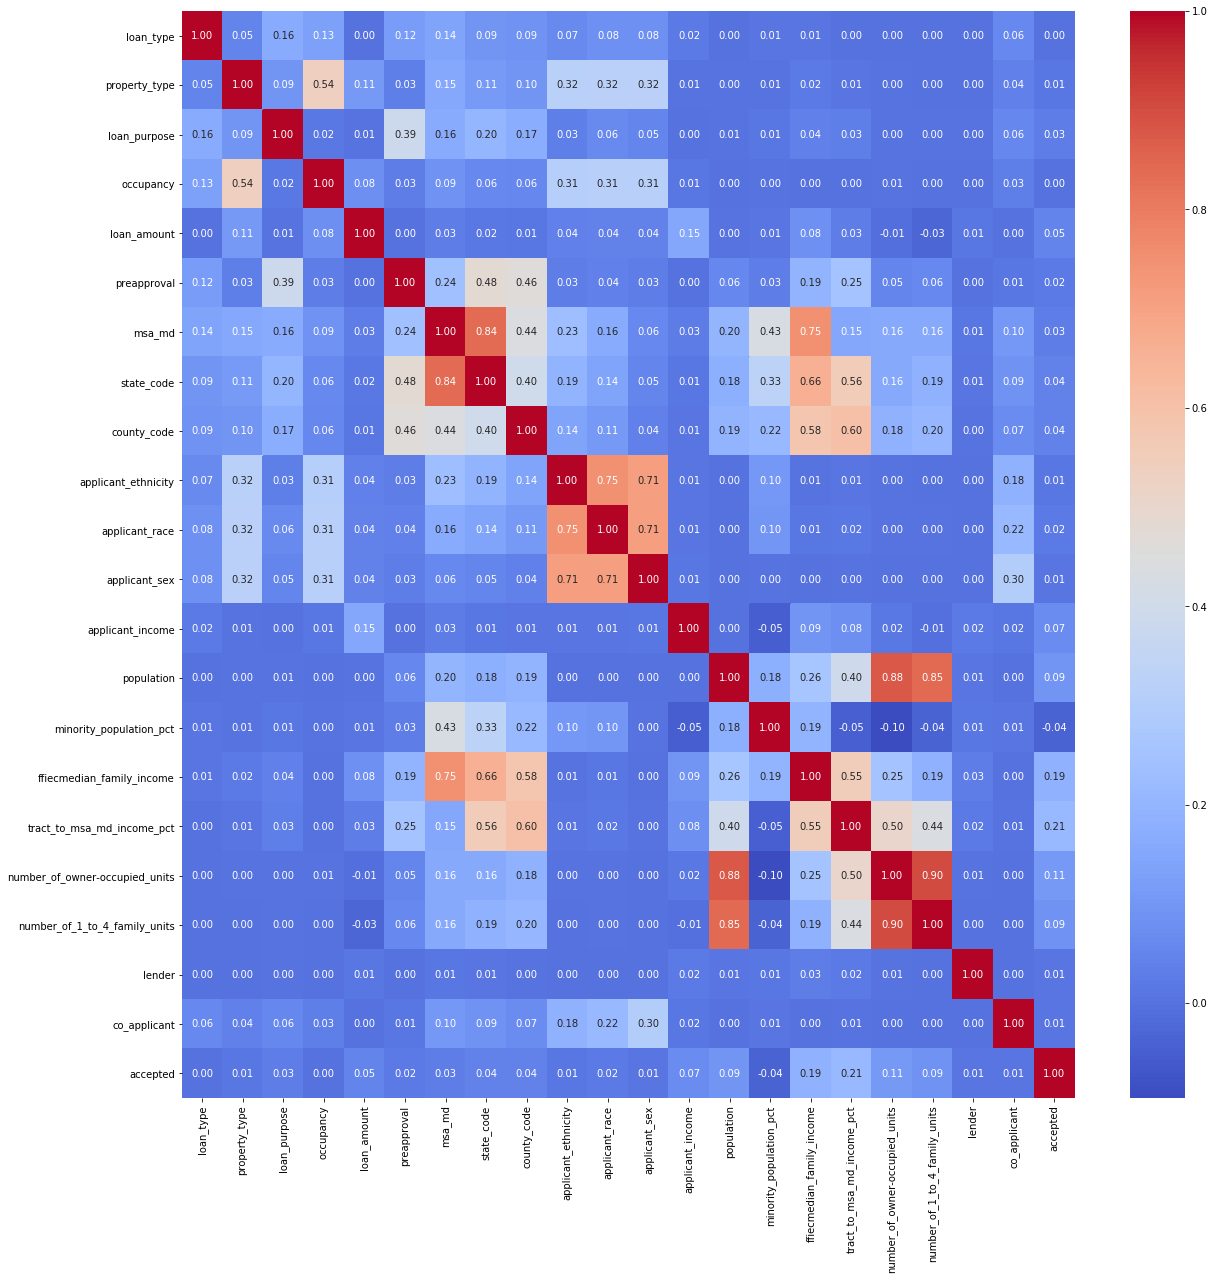

In [8]:
results = associations(data,nominal_columns=cols_cat,return_results=True)

The categorical columns msa_md, state_code and county_code have several -1 values indicating a missing value. It is to be determined whether these categorical features are important for the classification model.

Let's replace these missing values with median value for each column.

In [ ]:
cols_num_replace_nan =  ['applicant_income', 'number_of_owner-occupied_units', 'number_of_1_to_4_family_units',
                          'ffiecmedian_family_income', 'minority_population_pct', 'population']

rows = data[data[cols_num_replace_nan].isnull()].any(axis = 1)

dict_for_fillna = {col:data[col].dropna().median() for col in cols_num_replace_nan}

for key in dict_for_fillna.keys():
    print(key + ' ' + str(dict_for_fillna[key]))

In [ ]:
#data.fillna(value=dict_for_fillna, inplace=True)
data.fillna(method='ffill', inplace=True)
data[cols_num_replace_nan].isna().sum()

In [ ]:
data[data['accepted']==1].describe()

In [ ]:
data[data['accepted']==0].describe()

In [ ]:
data.info()

In [ ]:
DistPlots(data, cols_numerical)

In [ ]:
#log_cols_numerical = ['log_' + x for x in cols_numerical]
cols_to_log =  ['loan_amount',]
log_cols_numerical = ['log_' + x for x in cols_to_log]
print(log_cols_numerical)

data[log_cols_numerical] = data[cols_to_log].applymap(math.log)

In [ ]:
DistPlotsSplit(data, log_cols_numerical)

In [ ]:
BoxPlots(data, ['log_number_of_1_to_4_family_units'], ref=cols_categorical)

In [ ]:
#data.to_csv('train_values_log.csv')

There does not seem to be a strong prediction power by any of the numerical parameters, there is not sufficient distinction between the categories for accepted and rejected.

In [ ]:
CatPlots(data, cols_categorical)

In [ ]:
cols_property_location = ['msa_md', 'state_code', 'county_code', 'lender']

CategoricalPlots(data, cols_property_location)

Encoding

In [ ]:
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

In [ ]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories='auto')
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

Features = np.array([])

for col in cols_categorical:
    temp = encode_string(data[col])
    if Features.shape[0] == 0:
        Features = encode_string(data[col])
    else:
        Features = np.concatenate([Features, temp], axis = 1)

In [ ]:
Features.shape

In [ ]:
Features = np.concatenate([Features, np.array(data[['log_applicant_income', 'log_number_of_owner-occupied_units', 
                                                    'log_number_of_1_to_4_family_units', 'log_population',
                                                   'ffiecmedian_family_income', 'minority_population_pct']])], axis = 1)

In [ ]:
Features.shape

In [ ]:
import numpy.random as nr

nr.seed(6358)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 100000)
X_train = Features[indx[0],:]
y_train = np.ravel(labels['accepted'][indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels['accepted'][indx[1]])

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train[:,34:])
X_train[:,34:] = scaler.transform(X_train[:,34:])
X_test[:,34:] = scaler.transform(X_test[:,34:])
X_train[:2,]

In [ ]:
logistic_mod = linear_model.LogisticRegression() 
logistic_mod.fit(X_train, y_train)

In [ ]:
print(logistic_mod.intercept_)
print(logistic_mod.coef_)

In [ ]:
probabilities = logistic_mod.predict_proba(X_test)
print(probabilities[:15,:])

Score model

In [ ]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

In [ ]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores) 